In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import datetime
import datetime as dt
import numpy as np
import random
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
import quandl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_style("ticks")

In [3]:
# Quandl API calls
import sys
import os 
quandl.ApiConfig.api_key = "1FHran9s_sz2z6Vxgkvy"


#Equity Data
def Stock_Data(tickers):
    stocks = []
    stock_labels = []
    for i,k in tickers.items():
        WIKI_string = ("WIKI/"+i)
        data = quandl.get(WIKI_string,start_date="2016-8-17", end_date="2018-11-15")
        array = np.array(data.iloc[:,3])
        stocks.append(array)
        stock_labels.append(k)
#        plt.plot(array,label=k)
#        plt.legend()

#BEFORE YOU COLUMN STACK MAKE SURE STOCKS IS THE SAME LENGTH

    stock_twoD = np.column_stack(stocks)
    stocks_DF = pd.DataFrame(stock_twoD,columns=stock_labels)
        
    return stocks_DF, stock_labels

stock_basket = {"LUV":"Southwest Airlines", "INTC":"Intel", "AMZN":"Amazon", "GS":"Goldman Sachs", "MSFT":"Microsoft", 
                "AAPL": "Apple", "JPM": "JP Morgan", "CSCO": "Cisco", "QCOM": "Qualcom", "NKE":"Nike"}
stock_portfolio, stock_labels = Stock_Data(stock_basket)
stock_portfolio
#Currencies
tickers = ("EURAUD","EURMXN",'EURUSD','EURTRY')
def ECB_Data(tickers):
    ecb_pairs = []
    for i in tickers:
        x = ("ECB/"+i)
        data = quandl.get(x,start_date="2017-1-17", end_date="2018-11-15")
        array = np.array(data)
        ecb_pairs.append(array)
    return ecb_pairs

def fred_data(tickers):
    fred_pairs = []
    fred_labels = []
    for i,k in tickers.items():
        fred_string = ("FRED/"+i)
        data = quandl.get(fred_string,start_date="2016-10-17", end_date="2018-11-15")
        array = np.array(data)
        fred_pairs.append(array)
        fred_labels.append(k)
#         plt.plot(array,label=k)
#         plt.legend()
    two_d_pairs = np.column_stack(fred_pairs)
    fred_pairs_DF = pd.DataFrame(two_d_pairs,columns=fred_labels)
        
    return fred_pairs_DF, fred_labels

fred_tickers = {"DEXUSAL":"AUD/USD","DEXUSUK":"GBP/USD", "DEXCAUS": "USD/CAD", "DEXUSEU": "EUR/USD", "DEXJPUS": "USD/JPY", "DEXMXUS":"USD/MXN"}
fred_pairs,fred_labels = fred_data(fred_tickers)
#fred_pairs.head(10)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [40]:
#### Reading in Euro/Dollar Exchange Quotes
sp500_ = pd.read_csv("sp500.csv")
# jpy1 = pd.read_csv("jpy.csv")
# crude1  = pd.read_csv("Crude.csv")
# intc1 = pd.read_csv("intc.csv")
# nflx1 = pd.read_csv("nflx.csv")
# emini1 = pd.read_csv("e-mini.csv")


#Defining Dates and Closing Prices
sp500 = sp500_['Close']
# jpy = jpy1['Price']
# crude = crude1['Price']
# intc = intc1["Adj Close"]
# nflx = nflx1["Adj Close"]
# e_mini = emini1['Price']
# x = np.linspace(0,1,814)
# plt.plot(x,e_mini)


In [42]:
#Stru

def zero(basket):
    data  = np.copy(basket)
    hold = []
    for i in range(len(data)):
        lens = len(data[i])
        hold.append(lens)
    max_length = np.max(hold)
    for i in range(len(data)):
        while len(data[i]) <= max_length-1:
            replaced = np.insert(data[i],len(data[i]),0)
            data[i] = replaced
    stacked = np.column_stack(data)
    return stacked


def combine(structured_rets):
    combined_returns = []
    for i in range(len(structured_rets)):
        num_zeros = (structured_rets[[i],:] == 0).sum()
        column_sum = sum(structured_rets[i])
        length = len(structured_rets[i])
        average = column_sum/(length)
        combined_returns.append(average)
    
    running_sum = np.cumsum(combined_returns)
    return combined_returns



In [43]:
def tester(price_in,technical,long_or_short):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    slope = []

    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if delta_macd[i] > technical:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if delta_macd[i] < technical:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_macd = np.percentile(delta_macd[5:],85)
    min_macd = np.percentile(delta_macd[5:],15)

    return end_return, total_return, min_macd, max_macd

def random_walker(n,ls,close):
    starter = [0]    
    x_start, indicator, min_ind, max_ind = tester(close,starter[-1],str(ls))
    for i in range(n):
        test_x = np.random.uniform(min_ind,max_ind)
        random_return, indicator, minn,maxx = tester(close,test_x,str(ls))
        test_return, notimportant, minn,maxx = tester(close,starter[-1],str(ls))
        if random_return > test_return:
            starter.append(test_x)
    x,y,minn,maxx = tester(close,starter[-1],str(ls))
        
    return starter[-1]

In [26]:
def back_testing(price_in,long_indicator,short_indicator):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(macd)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = macd[i]-macd[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if delta_macd[i] > long_indicator:
            buys.append(i)
            mix.append(i)
        elif delta_macd[i] < short_indicator:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
#     for i in mix:
#         j = int(i)
#         j1 = int(i+1)
#         mix_return = ((price_in[j1] - price_in[j])/price_in[j])*100
#         mix_port.append(mix_return)        
        
#     for i in range(len(price_in)-1):
#         z = int(i)
#         z1 = int(i+1)
#         base = ((price_in[z1] - price_in[z])/price_in[z])*100
#         benchmark.append(base)

#     x_bench = np.linspace(0,1,len(benchmark))
    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))
#    fig, ax = plt.subplots(figsize=(12,5))

#     ax.plot(x_strat, np.cumsum(rets),label="Long Strategy")
#     ax.plot(x_bench, np.cumsum(benchmark),label="Benchmark")
#     ax.plot(x_short, np.cumsum(s_rets),label="Short Strategy")
#     ax.plot(x_mix, np.cumsum(mix_port),label="Mix Portfolio")

# #    ax2 = ax.twinx()
# #    ax2.plot(np.linspace(0,1,len(macd)), macd, 'r')
#     ax.yaxis.set_major_formatter(PercentFormatter())    
#     ax.legend(fontsize=15)
#     print("Strategy Return = %",sum(rets))
#     print("Total Return Outright = %",sum(benchmark))
    
#     #RISK ASSESMENT BENCHMARK
#     delta_returns = price_in.pct_change()
#     mean_returns = np.mean(delta_returns)
#     std_returns = np.std(delta_returns)
#     VAR_95 = norm.ppf(1-0.95,mean_returns, std_returns)*100
#     print("Benchmark VAR @ confidence Level = 95% Level", VAR_95)
    
#     #RISK ASSESMENT STRATEGY
#     #delta_returns_strat = price_in.pct_change()
#     mean_returns_strat = np.mean(rets)
#     std_returns_strat = np.std(rets)
#     VAR_95_strat = norm.ppf(1-0.95,mean_returns_strat, std_returns_strat)
#    print("Strategy VAR @ confidence Level = 95% Level", VAR_95_strat)
    return mix_port



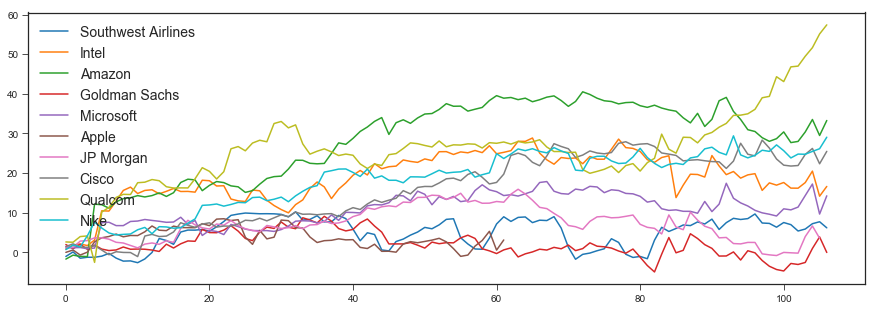

In [28]:
#labels = ("Euro/USD","NFLX","USD/JPY","Crude","E-Mini")
def best_indicator(n,prices,labels):
    long_ind = random_walker(n,"long",prices)
    short_ind = random_walker(n,"short",prices)
    returns = back_testing(prices,long_ind,short_ind)
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))

def portfolio_sim(n, portfolio, labels):
    basket = []
    for i in range(portfolio.shape[1]):
        column = str(labels[i])
        best_sim = best_indicator(n,portfolio[column], column)
        basket.append(best_sim)
        
    return basket

currency_returns = portfolio_sim(50,stock_portfolio,stock_labels)
        
        

#euro_returns = best_indicator(150,euro,"Euro/USD")
# nflx_returns = best_indicator(150,nflx,"NFLX")
# #intc_returns = best_indicator(100,intc)
# jpy_returns = best_indicator(150,jpy,"JPY/USD")
# crude_returns = best_indicator(150,crude,"Crude")
# e_mini_returns = best_indicator(150,e_mini,"S&P E-Mini Futures")
    


18.898556443015483
44.68537177647586


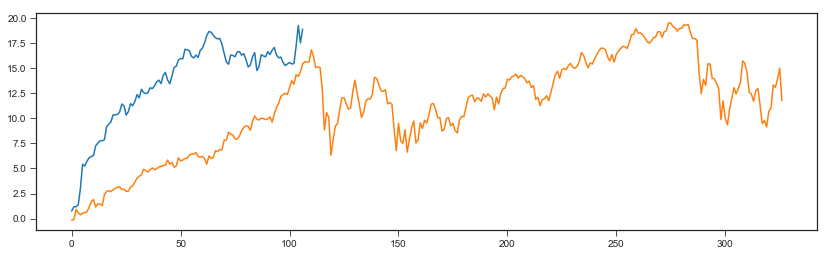

In [49]:
def percent_change(prices):
    daily_returns = []
    for i in range(len(prices)-1):
        z = int(i)
        z1 = int(i+1)
        change = ((prices[z1] - prices[z])/prices[z])*100
        daily_returns.append(change)
    combined_returns = np.cumsum(daily_returns)
    return combined_returns
sp500_returns = percent_change(sp500)
    
structured_returns = zero(currency_returns)
total_returns = combine(structured_returns)
cum_returns = np.cumsum(total_returns)

plt.figure(figsize=(14,4))

plt.plot(np.cumsum(total_returns))
plt.plot(sp500_returns)  

roi = cum_returns[-1]/(len(cum_returns)/253)
print(cum_returns[-1])
print(roi)



## SMA/LMA 

In [10]:
def SMALMAtester(price_in,SMA_ind,LMA_ind,long_or_short):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    LMA = price_in.rolling(window=LMA_ind).mean()
    SMA = price_in.rolling(window=SMA_ind).mean()
    diff = SMA - LMA
    delta_MA = diff.pct_change(periods=2)

    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if diff[i] > 0:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if diff[i] < 0:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_SMA = 50
    min_SMA = 5
    max_LMA = 200
    min_LMA = 50

    return end_return, total_return, max_SMA, min_SMA,max_LMA ,min_LMA


In [11]:
def random_walkerSMALMA(n,ls,close):
    starter = [5] 
    starter2 = [50] #will need two starters to make this work and update functions and the like
    x_start, indicator, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,starter[-1],starter2[-1],str(ls))
    for i in range(n):
        test_SMA = np.random.randint(min_SMA,max_SMA)
        test_LMA = np.random.randint(min_LMA,max_LMA)
        random_return, indicator, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,test_SMA,test_LMA,str(ls))
        test_return, notimportant, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,starter[-1],starter2[-1],str(ls))
        if random_return > test_return:
            starter.append(test_SMA)
            starter2.append(test_LMA)
    #x,y,minn,maxx = tester(close,starter[-1],starter2[-1],str(ls))
        
    return starter[-1] , starter2[-1]

random_walkerSMALMA(3,"long",e_mini)

NameError: name 'e_mini' is not defined

In [67]:
def back_testingSMALMA(price_in,SMA_ind,LMA_ind,SMA_indshort,LMA_indshort):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    LMA = price_in.rolling(window=LMA_ind).mean()
    SMA = price_in.rolling(window=SMA_ind).mean()
    diff = SMA - LMA
    delta_MA = diff.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(diff)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = diff[i]-diff[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if diff[i] > 0:
            buys.append(i)
            mix.append(i)
        elif diff[i] < 0:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
        x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))

    return mix_port

In [68]:
def best_indicatorSMALMA(n,prices,labels):
    #insert random walker function call and code here that simulates different windows for the rolling mean
    SMA,LMA = random_walkerSMALMA(n,"long",prices)
    SMAshort,LMAshort = random_walkerSMALMA(n,"short",prices)
    returns = back_testingSMALMA(prices,SMA,LMA,SMAshort,LMAshort) #plugs those here in place of 20/100
#    print(SMA,LMA,SMAshort,LMAshort)
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))
#


def portfolio_sim_SMA(n, portfolio, labels):
    basket = []
    for i in range(portfolio.shape[1]):
        column = str(labels[i])
        best_sim = best_indicatorSMALMA(n,portfolio[column], column)
        basket.append(best_sim)
        
    return basket

portfolio_sim_SMA(4, stock_portfolio, stock_labels)

C:\Users\jackb\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jackb\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\jackb\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 1080x360 with 0 Axes>